

---


**Importation de  tous les frameworks nécessaires**


---



In [ ]:
import sys

from numpy import vstack
from numpy import argmax
import numpy as np

from pandas import read_csv
import pandas as pd

import pickle

import torch
from torch import optim
from torch import nn
from torch import Tensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.nn import BCELoss
from torch.nn import BCELoss
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from torchvision import transforms
import seaborn as sns
import tensorflow as tf
import re
import string
import scipy
from tqdm import tqdm
from sklearn.datasets import make_multilabel_classification

import matplotlib.pyplot as plt
import matplotlib

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt
import matplotlib

import time

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english')) 
matplotlib.style.use('ggplot')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!




---


**Demande de connection á Drive et routage** 


---




In [ ]:
# pour monter son drive Google Drive local
from google.colab import drive
drive.mount('/content/gdrive')

my_local_drive='/content/gdrive/MyDrive/Colab Notebooks/PP2 Mio'
# Ajout du path pour les librairies, fonctions et données
sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
%cd $my_local_drive

%pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/PP2 Mio


'/content/gdrive/MyDrive/Colab Notebooks/PP2 Mio'

In [ ]:
# pour monter son drive Google Drive local
#from google.colab import drive
#drive.mount('/content/gdrive')
#my_local_drive='/content/gdrive/MyDrive/TER'
# Ajout du path pour les librairies, fonctions et données
#sys.path.append(my_local_drive)
# Se positionner sur le répertoire associé
#%cd $my_local_drive

#%pwd




---


# **Classification multiclass binaire**


---
▶
Cette première partie consiste en une classification multiclass. Autrement dit, sur cette partie le modèle est capable de savoir si l'opinion est positive ou négative et si appartient à Amazon ou à Imdb en même temps.

---
### **ETAPE 1 : Prétraitement du texte**

Fonction MyCleanText **(TransformerMixin)**
*   Mettre le texte en minuscule
*   Se débarasser des stopwords
*   Se débarasser des nombres
*   Stemmatisation
*   Lemmatisation

Fonction TextNormalizer

In [ ]:
def MyCleanText(X, 
               lowercase=False, # mettre en minuscule
               removestopwords=False, # supprimer les stopwords
               removedigit=False, # supprimer les nombres  
               getstemmer=False, # conserver la racine des termes
               getlemmatisation=False # lematisation des termes 
              ):
    
    sentence=str(X)

    # suppression des caractères spéciaux
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    # suppression de tous les caractères uniques
    sentence = re.sub(r'\s+[a-zA-Z]\s+', ' ', sentence)
    # substitution des espaces multiples par un seul espace
    sentence = re.sub(r'\s+', ' ', sentence, flags=re.I)

    # decoupage en mots
    tokens = word_tokenize(sentence)
    if lowercase:
          tokens = [token.lower() for token in tokens]

    # suppression ponctuation
    table = str.maketrans('', '', string.punctuation)
    words = [token.translate(table) for token in tokens]

    # suppression des tokens non alphabetique ou numerique
    words = [word for word in words if word.isalnum()]
    
    # suppression des tokens numerique
    if removedigit:
        words = [word for word in words if not word.isdigit()]

    # suppression des stopwords
    if removestopwords:
        words = [word for word in words if not word in stop_words]

    # lemmatisation
    if getlemmatisation:
        lemmatizer=WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word)for word in words]
        

    # racinisation
    if getstemmer:
        ps = PorterStemmer()
        words=[ps.stem(word) for word in words]
        
    sentence= ' '.join(words)
  
    return sentence   

from sklearn.base import BaseEstimator, TransformerMixin

class TextNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 removestopwords=False, # suppression des stopwords
                 lowercase=False,# passage en minuscule
                 removedigit=False, # supprimer les nombres  
                 getstemmer=False,# racinisation des termes 
                 getlemmatisation=False # lemmatisation des termes  
                ):
        
        self.lowercase=lowercase
        self.getstemmer=getstemmer
        self.removestopwords=removestopwords
        self.getlemmatisation=getlemmatisation
        self.removedigit=removedigit
        #self.transform = transforms.Compose([transforms.ToTensor()])  

    def transform(self, X, **transform_params):
        # Nettoyage du texte
        X=X.copy() # pour conserver le fichier d'origine
        return [MyCleanText(text,lowercase=self.lowercase,
                            getstemmer=self.getstemmer,
                            removestopwords=self.removestopwords,
                            getlemmatisation=self.getlemmatisation,
                            removedigit=self.removedigit) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self
    
    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X).transform(X)

    def get_params(self, deep=True):
        return {
            'lowercase':self.lowercase,
            'getstemmer':self.getstemmer,
            'removestopwords':self.removestopwords,
            'getlemmatisation':self.getlemmatisation,
            'removedigit':self.removedigit
        }    
    
    def set_params (self, **parameters):
        for parameter, value in parameters.items():
            setattr(self,parameter,value)
        return self    
        
        pipe = Pipeline([("cleaner", TextNormalizer(lowercase=True)),
                 ("tfidf_vectorizer", TfidfVectorizer(max_features=NB_FEATURES))])

        #pipe.fit(self.X)
        #self.X=pipe.transform(self.X)
        self.X=pipe.fit_transform(self.X)
        # sauvegarde du vocabulaire du TF_IDF pour tester d'autres données
        print (pipe.named_steps['tfidfvectorizer'].vocabulary)
        #corpus  = [tokenize(doc) for doc in self.X]
        #lexicon = gensim.corpora.Dictionary(corpus)
        #lexicon.save_as_text('lexicon.txt', sort_by_word=True)
        pickle.dump(pipe.named_steps['tfidfvectorizer'].vocabulary,open("feature.pkl","wb"))

        self.X=self.X.toarray()
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y)

---
### **ETAPE 2 : Création de l'ensemble de données multi-étiquettes**
Fonction make_dataset


*   Création de 10 000 points de données et chaque échantillon comporte 6 caractéristiques
*   Création du nombre d' étiquettes (n_classes) pour chaque point de données
*   Déclaration du nombre du nombre de classes possible (n_labels)
*   Création d'un 9900 échantillons d'entrainements
*   Création d'un 100 échantillons de test

In [ ]:
def make_dataset():
    x, y = make_multilabel_classification(
        n_samples=10000, n_features=6, n_classes=2, n_labels=2, random_state=1
    )
    # use 9900 samples for training
    x_train = x[:9900]
    y_train = y[:9900]
    # use 100 samples for testing
    x_test = x[-100:]
    y_test = y[-100:]
    return x_train, y_train, x_test, y_test

---

### **ETAPE 3 : Creation de l'ensemble de données pour un réseau neuronal de classification multi-têtes.**
Class MultiCategoryDataset 


*   Convertir des caractéristiques en tenseurs de type float32
*   Convertir les étiquettes en tenseurs de type de données float32. 

In [ ]:
# `MultiCategoryDataset()` for multi-head multi-category (2 or more) model
class MultiCategoryDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        features = self.x[index, :]
        labels = self.y[index, :]
        
        features = torch.tensor(features, dtype=torch.float32)
        label1 = torch.tensor(labels[0], dtype=torch.long)
        label2 = torch.tensor(labels[1], dtype=torch.long)
        return {
            'features': features,
            'label1': label1,
            'label2': label2,
        }

---
### **ETAPE 4 : Définition du modèle d'apprentissage en profondeur de classification multi-catégories**
Class MultiHeadMultiCategory


*   Définition de toutes les couches du réseau de neurones de notre modéle


In [ ]:
class MultiHeadMultiCategory(nn.Module):
    def __init__(self):
        super(MultiHeadMultiCategory, self).__init__()
        self.fc1 = nn.Linear(6, 32) # 12 is the number of features
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        
        # we will treat each head as a multi-category classifier ...
        # ... so the output features will be 2 (0 and 1)
        self.out1 = nn.Linear(256, 2)
        self.out2 = nn.Linear(256, 2)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        out1 = F.sigmoid(self.out1(x))
        out2 = F.sigmoid(self.out2(x))
        
        return out1, out2

---
### **ETAPE 5 :Définition de la fonction de perte multi-catégories**
Fonction multi_category_loss_fn


*   Calcul la moyenne des valeurs de perte


In [ ]:
#custom loss function for multi-head multi-category classification
def multi_category_loss_fn(outputs, targets):
    o1, o2 = outputs
    t1, t2 = targets
    l1 = nn.CrossEntropyLoss()(o1, t1)
    l2 = nn.CrossEntropyLoss()(o2, t2)
    return (l1 + l2) / 2

---


### **ETAPE 6 : Creation du dataset**

Extraction et création d'une matrice à partir des jeux données fournis. 

In [ ]:
start_time = time.time()
path ='ReviewsLabelled.csv'
df=read_csv(path,header=0, sep='\t', encoding='utf8')
print("DataSet :", df.shape ,"\n")
le=LabelEncoder()
df.source=le.fit_transform(df.source)

df2=pd.DataFrame(df, columns =
                 ['sentence','sentiment' ,'source' ])

print("Dataset binaire | Opinion : Negative ou Positive | Sources : Amazon ou Ibmn ou Yelp :",df2.shape, "\n")
df2['target_list'] = df2[['sentiment', 'source']].values.tolist()

final_df=df2[['sentence','target_list']].copy()

print(final_df)

DataSet_time = " %s seconds \n" % (time.time() - start_time)

DataSet : (3000, 3) 

Dataset binaire | Opinion : Negative ou Positive | Sources : Amazon ou Ibmn ou Yelp : (3000, 3) 

                                               sentence target_list
0     So there is no way for me to plug it in here i...      [0, 0]
1                           Good case, Excellent value.      [1, 0]
2                                Great for the jawbone.      [1, 0]
3     Tied to charger for conversations lasting more...      [0, 0]
4                                     The mic is great.      [1, 0]
...                                                 ...         ...
2995  I think food should have flavor and texture an...      [0, 2]
2996                           Appetite instantly gone.      [0, 2]
2997  Overall I was not impressed and would not go b...      [0, 2]
2998  The whole experience was underwhelming, and I ...      [0, 2]
2999  Then, as if I hadn't wasted enough of my life ...      [0, 2]

[3000 rows x 2 columns]


---
### **ETAPE 7 : Preparation et Initialisation**


*   Creation des tableaux NumPy x_train et y_train á partir de la fonction **make_dataset()**
*   Préparation de **train_dataset** 
*   Préparation de **train_dataloader**
*   Initialisation du classificateur binaire multi-têtes


In [ ]:
#prepare the dataset
x_train, y_train, _, _ = make_dataset()
# print some info
print(f"[INFO]: Number of training samples: {x_train.shape[0]}")
print(f"[INFO]: Number of training features: {x_train.shape[1]}")
# train dataset
train_dataset = MultiCategoryDataset(x_train, y_train)
# train data loader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1024)
# initialize the model
model = MultiHeadMultiCategory()

[INFO]: Number of training samples: 9900
[INFO]: Number of training features: 6




---

### **Etape 8 : Définition de la fonction d'entrainements**
Fonction train 


*   Permet l'entraînement de notre modèle


In [ ]:
# training function
def train(model, dataloader, optimizer, loss_fn, train_dataset, device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_dataset)/dataloader.batch_size)):
        counter += 1
        
        # extract the features and labels
        features = data['features'].to(device)
        target1 = data['label1'].to(device)
        target2 = data['label2'].to(device)
        
        # zero-out the optimizer gradients
        optimizer.zero_grad()
        
        outputs = model(features)
        targets = (target1, target2)
        loss = loss_fn(outputs, targets)
        train_running_loss += loss.item()
        
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss



---
### **ETAPE 9: Entrainement du modèle**
Defintion des paramètres d'apprentissage et entraînement de notre modèle.


In [ ]:
# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100 #initialement 100
# load the model on to the computation device
model.to(device)
# start the training
start_time = time.time()
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, multi_category_loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
training_time = " %s seconds \n" % (time.time() - start_time)

Epoch 1 of 100


  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
10it [00:00, 23.83it/s]                      


Train Loss: 0.6656
Epoch 2 of 100


10it [00:00, 33.25it/s]                      


Train Loss: 0.5882
Epoch 3 of 100


10it [00:00, 32.70it/s]                      


Train Loss: 0.4967
Epoch 4 of 100


10it [00:00, 32.03it/s]                      


Train Loss: 0.4537
Epoch 5 of 100


10it [00:00, 32.30it/s]                      


Train Loss: 0.4288
Epoch 6 of 100


10it [00:00, 33.77it/s]                      


Train Loss: 0.4142
Epoch 7 of 100


10it [00:00, 31.72it/s]                      


Train Loss: 0.4071
Epoch 8 of 100


10it [00:00, 32.82it/s]                      


Train Loss: 0.4012
Epoch 9 of 100


10it [00:00, 32.24it/s]                      


Train Loss: 0.3968
Epoch 10 of 100


10it [00:00, 34.25it/s]                      


Train Loss: 0.3938
Epoch 11 of 100


10it [00:00, 20.21it/s]                      


Train Loss: 0.3908
Epoch 12 of 100


10it [00:00, 33.42it/s]                      


Train Loss: 0.3887
Epoch 13 of 100


10it [00:00, 31.84it/s]                      


Train Loss: 0.3865
Epoch 14 of 100


10it [00:00, 31.88it/s]                      


Train Loss: 0.3852
Epoch 15 of 100


10it [00:00, 32.06it/s]                      


Train Loss: 0.3830
Epoch 16 of 100


10it [00:00, 31.28it/s]                      


Train Loss: 0.3822
Epoch 17 of 100


10it [00:00, 30.30it/s]                      


Train Loss: 0.3800
Epoch 18 of 100


10it [00:00, 32.08it/s]                      


Train Loss: 0.3784
Epoch 19 of 100


10it [00:00, 31.33it/s]                      


Train Loss: 0.3776
Epoch 20 of 100


10it [00:00, 31.93it/s]                      


Train Loss: 0.3791
Epoch 21 of 100


10it [00:00, 20.82it/s]                      


Train Loss: 0.3768
Epoch 22 of 100


10it [00:00, 31.28it/s]                      


Train Loss: 0.3759
Epoch 23 of 100


10it [00:00, 31.27it/s]                      


Train Loss: 0.3756
Epoch 24 of 100


10it [00:00, 30.93it/s]                      


Train Loss: 0.3763
Epoch 25 of 100


10it [00:00, 31.49it/s]                      


Train Loss: 0.3746
Epoch 26 of 100


10it [00:00, 31.74it/s]                      


Train Loss: 0.3742
Epoch 27 of 100


10it [00:00, 32.73it/s]                      


Train Loss: 0.3743
Epoch 28 of 100


10it [00:00, 30.71it/s]                      


Train Loss: 0.3748
Epoch 29 of 100


10it [00:00, 31.84it/s]                      


Train Loss: 0.3757
Epoch 30 of 100


10it [00:00, 30.37it/s]                      


Train Loss: 0.3738
Epoch 31 of 100


10it [00:00, 30.76it/s]                      


Train Loss: 0.3743
Epoch 32 of 100


10it [00:00, 20.55it/s]


Train Loss: 0.3743
Epoch 33 of 100


10it [00:00, 31.70it/s]                      


Train Loss: 0.3737
Epoch 34 of 100


10it [00:00, 30.91it/s]


Train Loss: 0.3741
Epoch 35 of 100


10it [00:00, 32.29it/s]                      


Train Loss: 0.3736
Epoch 36 of 100


10it [00:00, 33.22it/s]                      


Train Loss: 0.3730
Epoch 37 of 100


10it [00:00, 31.22it/s]                      


Train Loss: 0.3730
Epoch 38 of 100


10it [00:00, 32.41it/s]                      


Train Loss: 0.3751
Epoch 39 of 100


10it [00:00, 33.42it/s]                      


Train Loss: 0.3743
Epoch 40 of 100


10it [00:00, 30.30it/s]                      


Train Loss: 0.3741
Epoch 41 of 100


10it [00:00, 32.13it/s]                      


Train Loss: 0.3738
Epoch 42 of 100


10it [00:00, 32.53it/s]                      


Train Loss: 0.3728
Epoch 43 of 100


10it [00:00, 20.39it/s]                      


Train Loss: 0.3727
Epoch 44 of 100


10it [00:00, 31.87it/s]                      


Train Loss: 0.3741
Epoch 45 of 100


10it [00:00, 32.68it/s]                      


Train Loss: 0.3734
Epoch 46 of 100


10it [00:00, 31.54it/s]                      


Train Loss: 0.3728
Epoch 47 of 100


10it [00:00, 29.71it/s]                      


Train Loss: 0.3729
Epoch 48 of 100


10it [00:00, 32.13it/s]                      


Train Loss: 0.3722
Epoch 49 of 100


10it [00:00, 31.21it/s]                      


Train Loss: 0.3729
Epoch 50 of 100


10it [00:00, 31.29it/s]                      


Train Loss: 0.3727
Epoch 51 of 100


10it [00:00, 31.75it/s]                      


Train Loss: 0.3724
Epoch 52 of 100


10it [00:00, 31.68it/s]                      


Train Loss: 0.3719
Epoch 53 of 100


10it [00:00, 32.58it/s]                      


Train Loss: 0.3726
Epoch 54 of 100


10it [00:00, 31.70it/s]                      


Train Loss: 0.3730
Epoch 55 of 100


10it [00:00, 31.54it/s]                      


Train Loss: 0.3722
Epoch 56 of 100


10it [00:00, 20.69it/s]                      


Train Loss: 0.3727
Epoch 57 of 100


10it [00:00, 32.70it/s]                      


Train Loss: 0.3726
Epoch 58 of 100


10it [00:00, 30.61it/s]                      


Train Loss: 0.3721
Epoch 59 of 100


10it [00:00, 32.88it/s]                      


Train Loss: 0.3718
Epoch 60 of 100


10it [00:00, 32.39it/s]                      


Train Loss: 0.3719
Epoch 61 of 100


10it [00:00, 31.00it/s]                      


Train Loss: 0.3737
Epoch 62 of 100


10it [00:00, 31.47it/s]                      


Train Loss: 0.3726
Epoch 63 of 100


10it [00:00, 31.69it/s]                      


Train Loss: 0.3723
Epoch 64 of 100


10it [00:00, 31.18it/s]                      


Train Loss: 0.3720
Epoch 65 of 100


10it [00:00, 29.99it/s]                      


Train Loss: 0.3718
Epoch 66 of 100


10it [00:00, 30.79it/s]                      


Train Loss: 0.3712
Epoch 67 of 100


10it [00:00, 29.22it/s]                      


Train Loss: 0.3719
Epoch 68 of 100


10it [00:00, 30.05it/s]                      


Train Loss: 0.3728
Epoch 69 of 100


10it [00:00, 29.55it/s]


Train Loss: 0.3716
Epoch 70 of 100


10it [00:00, 19.82it/s]                      


Train Loss: 0.3717
Epoch 71 of 100


10it [00:00, 29.36it/s]                      


Train Loss: 0.3719
Epoch 72 of 100


10it [00:00, 28.66it/s]                      


Train Loss: 0.3713
Epoch 73 of 100


10it [00:00, 26.72it/s]                      


Train Loss: 0.3712
Epoch 74 of 100


10it [00:00, 29.36it/s]                      


Train Loss: 0.3712
Epoch 75 of 100


10it [00:00, 29.83it/s]                      


Train Loss: 0.3712
Epoch 76 of 100


10it [00:00, 29.67it/s]


Train Loss: 0.3710
Epoch 77 of 100


10it [00:00, 28.12it/s]


Train Loss: 0.3712
Epoch 78 of 100


10it [00:00, 27.73it/s]                      


Train Loss: 0.3712
Epoch 79 of 100


10it [00:00, 27.70it/s]                      


Train Loss: 0.3713
Epoch 80 of 100


10it [00:00, 29.23it/s]


Train Loss: 0.3708
Epoch 81 of 100


10it [00:00, 28.98it/s]                      


Train Loss: 0.3710
Epoch 82 of 100


10it [00:00, 19.19it/s]                      


Train Loss: 0.3707
Epoch 83 of 100


10it [00:00, 31.47it/s]                      


Train Loss: 0.3708
Epoch 84 of 100


10it [00:00, 30.08it/s]                      


Train Loss: 0.3712
Epoch 85 of 100


10it [00:00, 30.85it/s]


Train Loss: 0.3705
Epoch 86 of 100


10it [00:00, 29.61it/s]                      


Train Loss: 0.3706
Epoch 87 of 100


10it [00:00, 30.15it/s]


Train Loss: 0.3706
Epoch 88 of 100


10it [00:00, 30.41it/s]                      


Train Loss: 0.3708
Epoch 89 of 100


10it [00:00, 30.25it/s]


Train Loss: 0.3717
Epoch 90 of 100


10it [00:00, 30.02it/s]                      


Train Loss: 0.3717
Epoch 91 of 100


10it [00:00, 30.64it/s]                      


Train Loss: 0.3709
Epoch 92 of 100


10it [00:00, 30.69it/s]


Train Loss: 0.3709
Epoch 93 of 100


10it [00:00, 28.86it/s]                      


Train Loss: 0.3708
Epoch 94 of 100


10it [00:00, 29.77it/s]                      


Train Loss: 0.3718
Epoch 95 of 100


10it [00:00, 27.85it/s]                      


Train Loss: 0.3708
Epoch 96 of 100


10it [00:00, 19.35it/s]


Train Loss: 0.3713
Epoch 97 of 100


10it [00:00, 28.76it/s]                      


Train Loss: 0.3707
Epoch 98 of 100


10it [00:00, 29.74it/s]


Train Loss: 0.3701
Epoch 99 of 100


10it [00:00, 28.59it/s]                      


Train Loss: 0.3709
Epoch 100 of 100


10it [00:00, 29.45it/s]                      

Train Loss: 0.3724


---
### **ETAPE 10 :**

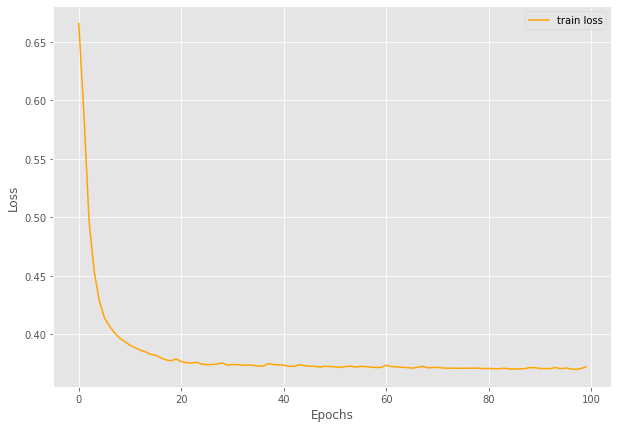

In [ ]:
PATH="multi_head_multi_category.pt"
torch.save(model.state_dict(), PATH)
# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/multi_head_multi_category_loss.png')
plt.show()

---
### **ETAPE 11 : Temps**

In [ ]:
start_time = time.time()
train(model, train_dataloader, optimizer, multi_category_loss_fn, train_dataset , device)
print("\n")
print("Temps de entrainements : %s seconds \n" % (time.time() - start_time))
start_time = time.time()
MultiCategoryDataset(x_train, y_train)
print("BinaryDataset : %s seconds \n" % (time.time() - start_time))
start_time = time.time()
MultiHeadMultiCategory()
print("MultiHeadBinaryModel : %s seconds \n" % (time.time() - start_time))
print("Train Loss : ", training_time  )
print("DataSet : ", DataSet_time  )

  0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
10it [00:00, 16.31it/s]



Temps de entrainements : 0.6275999546051025 seconds 

BinaryDataset : 0.00010180473327636719 seconds 

MultiHeadBinaryModel : 0.0021250247955322266 seconds 

Train Loss :   34.93103861808777 seconds 

DataSet :   0.4664638042449951 seconds 





---

# **ZONE DE TEST**

---

